In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, FormatStrFormatter
import math
import numpy as np
import matplotlib.pylab as pl

In [2]:
n_measurements = 20 #no. of different values used
max_gRate = 0.083
immigration_rate = 0.8
K = 10000
#when deterioration greater than this value we change from immigration dominated to deterioration dominated
phase2_lim = immigration_rate/K 
phase2_lim_scaled = phase2_lim/max_gRate

N_thresh_min = 0. #range of values for N*
N_thresh_max = 1.5
delta_N_thresh = (N_thresh_max - N_thresh_min)/n_measurements

det_ratio_min = 0. #range of values for deterioration ratio
det_ratio_max = 1.5
delta_det_ratio = (det_ratio_max - det_ratio_min)/n_measurements

det_ratio_vals = np.linspace(det_ratio_min, det_ratio_max, 101)

In [3]:
dashed_line_vals = pd.read_csv("chris_deterministic_data/dashed_im0.8_mig0.8.dat", delimiter=" ", header=None, skiprows=1, names=["r_det_ratio", "N_theory"])
#dashed_line_vals

In [4]:
def phase_diag_line(r_det_g):
    '''
    This method calculates the theoretical blue line used for the time to first microhabitat phase diagram.
    
    Given by eqn 3 (subject to change) in the biofilm threshold theory paper
    
    r_det_g is a value of r_det/g_max
    '''
    
#     N_plus = K*(1 - r_det_g)*(0.5 + 0.5*(1. + (4.*immigration_rate)/(max_gRate*K*(1 - r_det_g)**0.5) ))
#     N_minus = K*(1 - r_det_g)*(0.5 - 0.5*(1. + (4.*immigration_rate)/(max_gRate*K*(1 - r_det_g)**0.5) ))
    
#     N_plus  = (1. - r_det_g)*(0.5+0.5*(1+(4.*immigration_rate/(max_gRate*K*(1 - r_det_g)**2)))**0.5)
#     N_minus = (1. - r_det_g)*(0.5-0.5*(1+(4.*immigration_rate/(max_gRate*K*(1 - r_det_g)**2)))**0.5)
    N_plus  = (1. - r_det_g)*(0.5 + 0.5*(1 + (4.*immigration_rate/((1 - r_det_g)**2)))**0.5)
    N_minus = (1. - r_det_g)*(0.5 - 0.5*(1 + (4.*immigration_rate/((1 - r_det_g)**2)))**0.5)
    
    return np.max([N_plus, N_minus])
    
    

In [5]:
df2 = pd.read_csv("timeTo1Microhab_phaseDiagram_bigK/mhLim-1_N^-1.500_rDet-0.225.csv")
new_df = pd.DataFrame(df2.mean().to_dict(),index=[df2.index.values[-1]])
new_df["time_to_n_stDev"] = df2["time_to_n"].std()
new_df["coeff_variation"] = df2["time_to_n"].std()/df2["time_to_n"].mean()
new_df
#df2
df3 = pd.read_csv("timeTo1Microhab_phaseDiagram_bigK/mhLim-1_N^-1.200_rDet-0.675.csv")
#df3


In [6]:
df_list = [] #empty list to hold all the dataframes
#iterate through all the seperate csv files and append them to the list
for n in range(n_measurements+1):
    for d in range(n_measurements+1):
        n_thresh = N_thresh_min + n*(delta_N_thresh)
        det_ratio = det_ratio_min + d*(delta_det_ratio)
        
        n_thresh_str = "{:.3f}".format(n_thresh)
        det_ratio_str = "{:.3f}".format(det_ratio)
        
        df = pd.read_csv("timeTo1Microhab_phaseDiagram_bigK/mhLim-1_N^-"+n_thresh_str+"_rDet-"+det_ratio_str+".csv")
        df['time_to_n_raw'] = df['time_to_n']
        df['time_to_n'] = df['time_to_n']*max_gRate
        
        averaged_df = pd.DataFrame(df.mean().to_dict(),index=[df.index.values[-1]])
        averaged_df["time_to_n_stDev"] = df["time_to_n"].std()
        averaged_df["coeff_variation"] = df["time_to_n"].std()/df["time_to_n"].mean() if df["time_to_n"].mean() > 0 else None

        df_list.append(averaged_df)
        

In [7]:
#add all the dataframes together
param_data = pd.concat(df_list ,ignore_index=True)
#param_data = param_data.rename({'det_rate_ratio': 'det_rate'}, axis='columns')
#param_data['det_ratio'] = param_data['det_rate']/max_gRate
#param_data['time_adjusted'] = 0 if math.isclose(param_data['time_to_n'], 0) and param_data["time_elapsed"] > 5e5

# if param_data['time_to_n'] == 0 and param_data["time_elapsed"] > 5e5:
#     param_data['time_adjusted'] = 0.
    
# elif param_data['time_to_n'] == 0  and param_data["time_elapsed"] < 5e5:
#     param_data['time_adjusted'] = None
    
# else: param_data['time_adjusted'] = param_data['time_to_n']
#filterinfDataframe = dfObj[(dfObj['Sale'] > 30) & (dfObj['Sale'] < 33) ]
#
param_data['tN_adjusted'] = param_data["time_to_n"]
param_data['tN_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] > 5e5)] = 0.
param_data['tN_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] < 5e5)] = None

param_data['tN_stDev_adjusted'] = param_data["time_to_n_stDev"]
param_data['tN_stDev_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] > 5e5)] = 0.
param_data['tN_stDev_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] < 5e5)] = None

param_data['stochasticity'] = param_data['tN_stDev_adjusted']
param_data['stochasticity'][(param_data['stochasticity'] > 0.) & param_data['stochasticity']] = param_data['tN_stDev_adjusted']/param_data['tN_adjusted']

#this line below is essential for some reason to avoid duplicate entries
param_data[param_data['time_to_n'] > 0]

print(len(param_data.index))
print(np.nanmean(param_data["tN_adjusted"]))
print(np.nanmedian(param_data["tN_adjusted"]))
#just fiddling around here to limit the range of values in the colour bar
'''UNCOMMENT THE BELOW LINE TO GET THE NICE LOOKING HEATMAP'''
#param_data["tN_adjusted"][param_data["tN_adjusted"] > 3] = 3
#param_data
param_data["coeff_variation"][(param_data["coeff_variation"] > 0.22) | (param_data["tN_adjusted"] > 3)] = 0.22
param_data["coeff_variation"][np.isclose(param_data["n_thresh"], 0.)] = 0
#param_data["coeff_variation"][param_data["tN_adjusted"] > 3] = None

(param_data[param_data["tN_adjusted"] > 0].sort_values(by=['coeff_variation', 'tN_adjusted'], ascending=False).head())

441
0.9974744917161228
0.7222729166666667


,n_thresh,det_ratio,time_to_n,time_elapsed,time_to_n_raw,time_to_n_stDev,coeff_variation,tN_adjusted,tN_stDev_adjusted,stochasticity
386,1.350,0.600,10.745211,9.000000e+09,129.460375,2.865178,0.22,10.745211,2.865178,0.266647
345,1.200,0.675,9.393044,9.000000e+09,113.169208,2.869919,0.22,9.393044,2.869919,0.305537
427,1.500,0.525,6.731860,9.000000e+09,81.106750,0.614248,0.22,6.731860,0.614248,0.091245
228,0.750,1.350,4.761084,9.000000e+09,57.362458,1.656502,0.22,4.761084,1.656502,0.347925
406,1.425,0.525,4.588475,9.000000e+09,55.282833,0.212990,0.22,4.588475,0.212990,0.046419


In [8]:
pivot = param_data.pivot(index='n_thresh', columns='det_ratio', values='time_to_n_raw')

In [9]:
theoryvals = np.vectorize(phase_diag_line)(det_ratio_vals)

1.52469507659596
0.6787087810503355
1.45608311
1.00191157


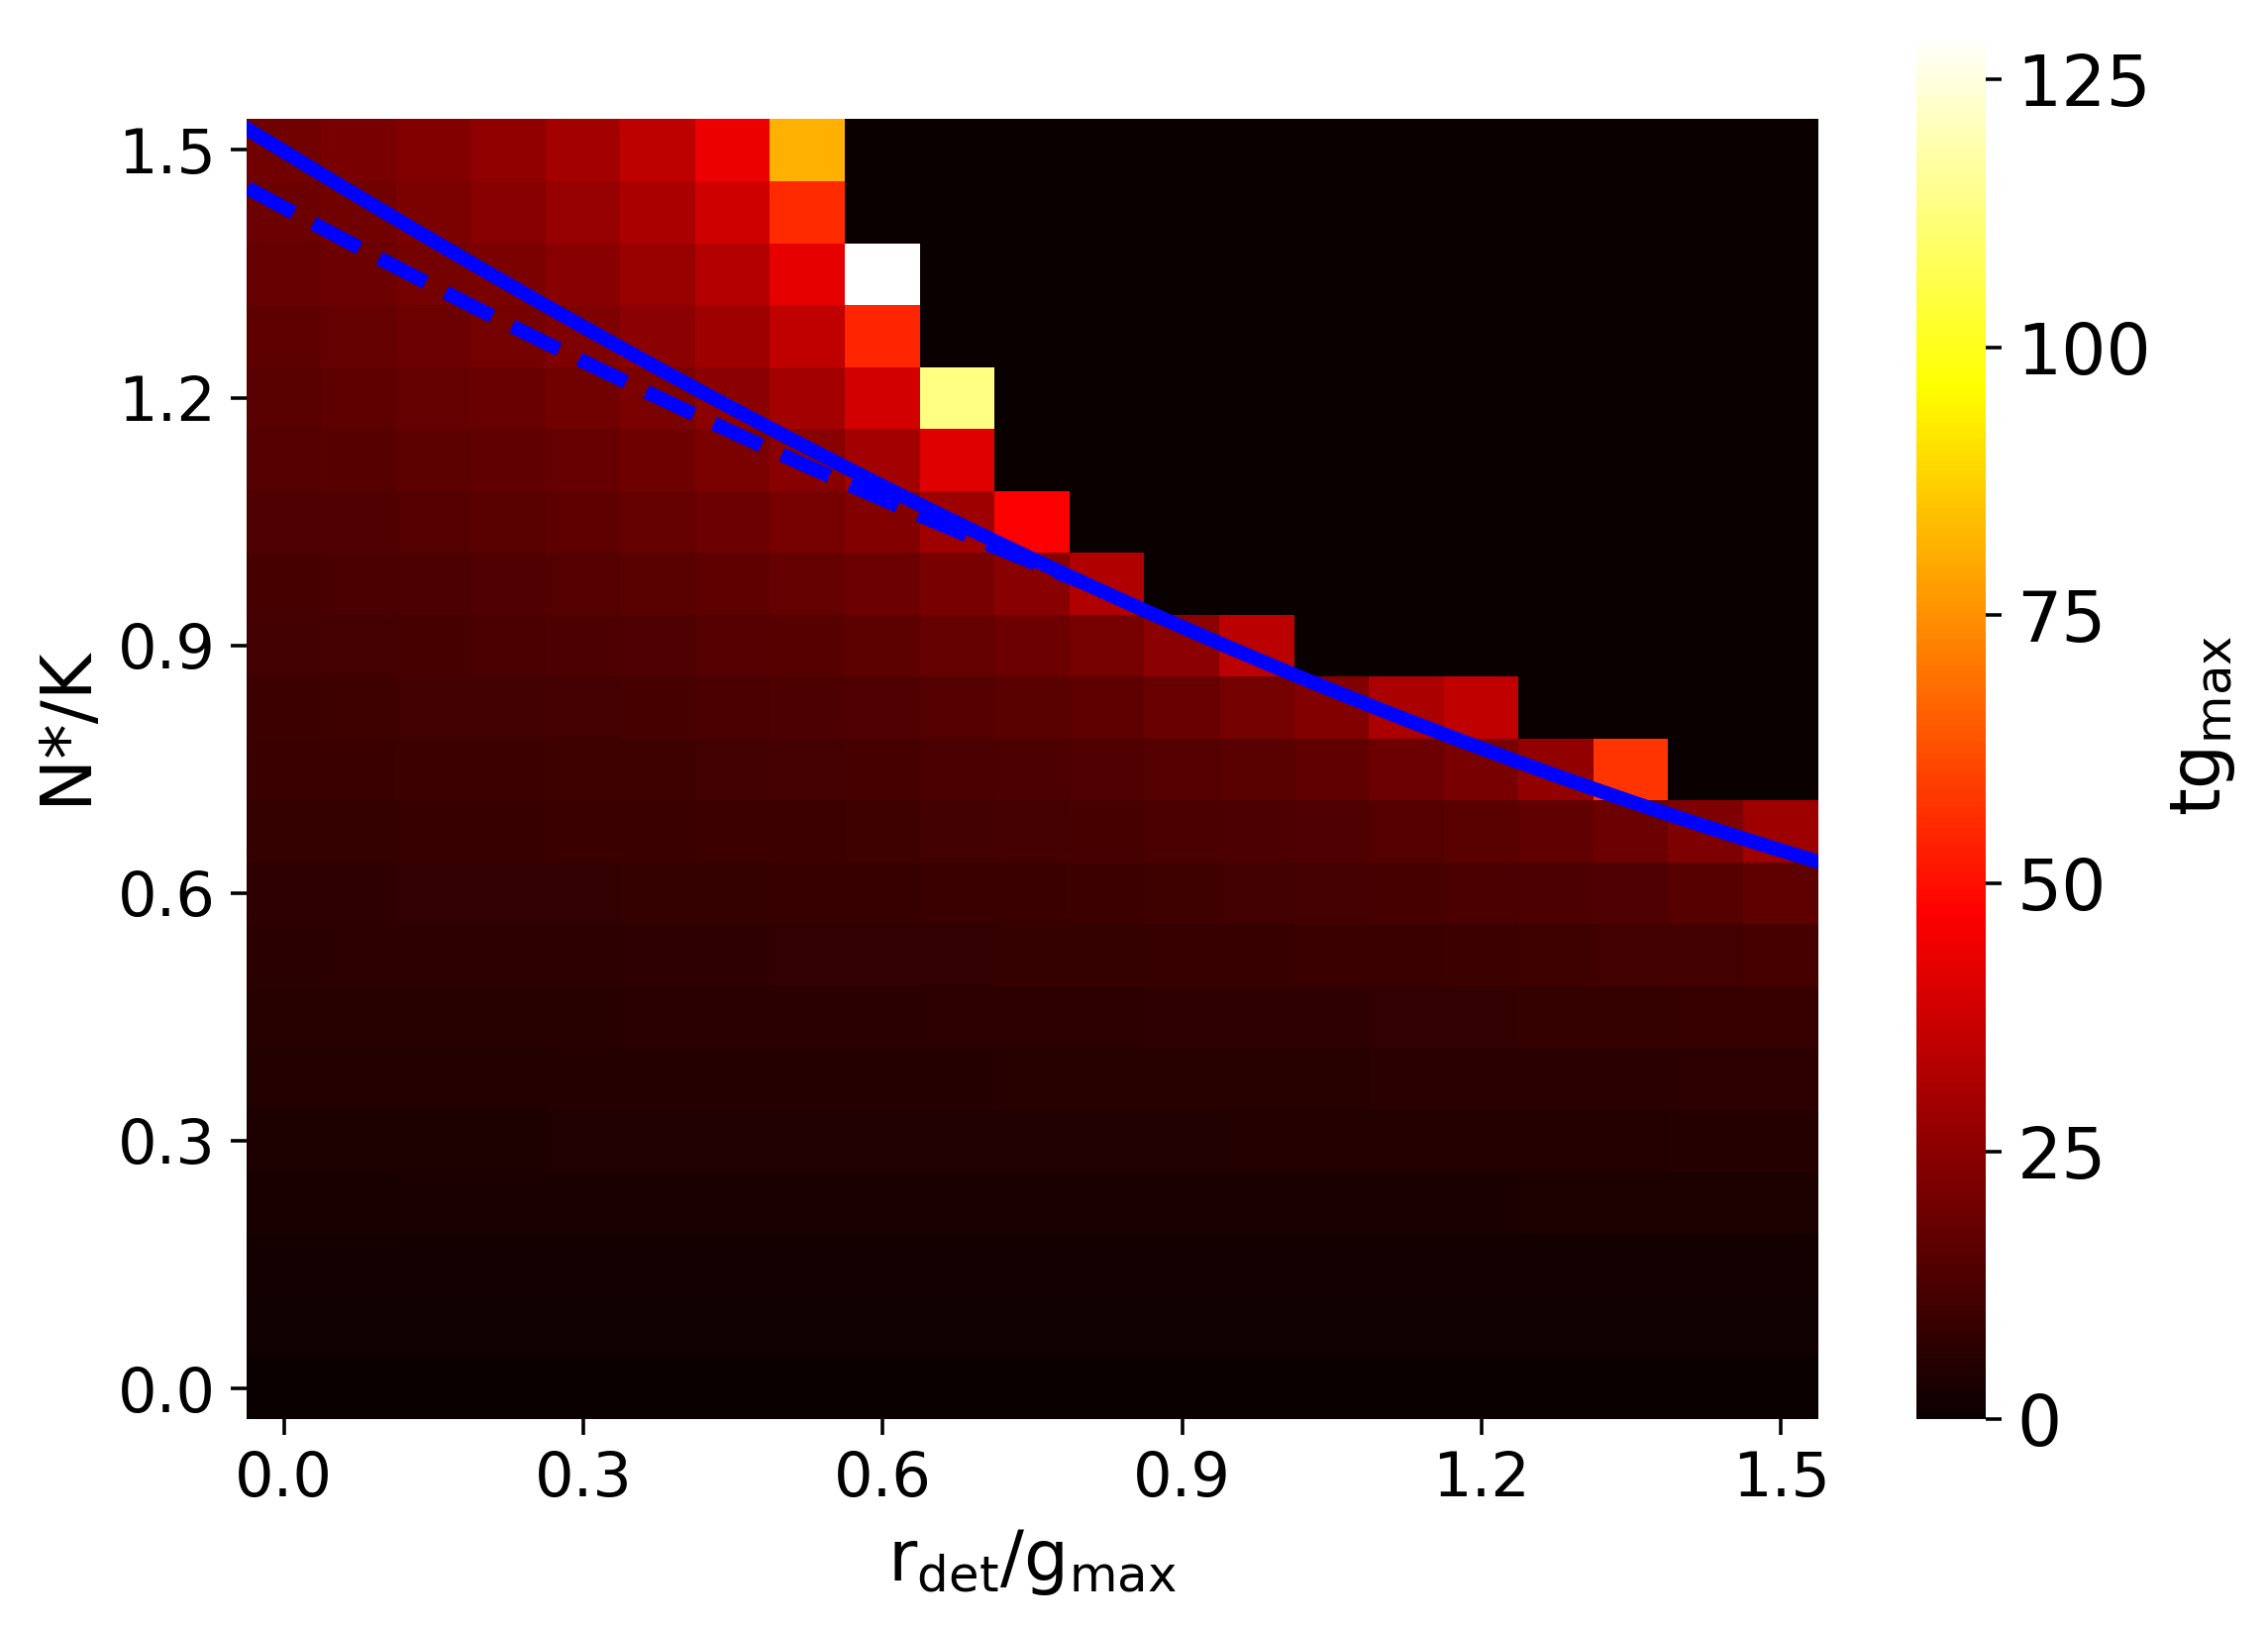

In [10]:
fig, ax = plt.subplots(dpi=320)
fig.set_size_inches(8, 5.8)
titleSize = 16
labelSize = 16
numbersize = 14
legendsize = 10
IDsize=12


# #this mask will only plot values between 15 and 20
# masko = (pivot < 15) | (pivot >= 20)

# #phase_mask = (pivot['det_ratio']) > 0.5

ax = sns.heatmap(pivot, annot=False, cmap='hot', xticklabels = 4, yticklabels=4, rasterized=True)
# ax_masked = sns.heatmap(pivot, mask=masko, cmap='Greens', cbar=False, annot=True)
# #ax_masked2 = sns.heatmap(pivot, mask=phase_mask, cmap='Blues', cbar=False, annot=True)

ax.invert_yaxis()
labels_x = [label.get_text() for label in ax.get_xticklabels()]
ax.set_xticklabels(map(lambda x: "{:.1f}".format(float(x)), labels_x))
labels_y = [label.get_text() for label in ax.get_yticklabels()]
ax.set_yticklabels(map(lambda y: "{:.1f}".format(float(y)), labels_y))


#plot the theoretical blue line #####################
theoryN_vals = np.vectorize(phase_diag_line)(det_ratio_vals)
# theoryN_vals[0] = 1.5
# theoryN_vals[-1] = 0.6
print(theoryN_vals[0])
print(theoryN_vals[-1])

#in order to get the line to be positioned correctly, need to multiply it by this scale factor.
#equal to the max value of the line divided by no. of squares in each axis
nsquares = len(param_data.index)**0.5 #no. of squares in each axis
scale_factor_x = nsquares/1.5
scale_factor_y = nsquares/1.5
sns.lineplot(x=det_ratio_vals*scale_factor_x, y=theoryN_vals*scale_factor_y, linewidth = 3.2, color="blue")
line = ax.lines[0] # get the line
line.set_ydata(line.get_ydata() - 0.5)



#plot the dashed line
det_ratio_vals_dashed = dashed_line_vals["r_det_ratio"]
theoryN_vals_dashed = dashed_line_vals["N_theory"]
print(theoryN_vals_dashed[0])
print(np.min(theoryN_vals_dashed))

scale_factor_x_dashed = nsquares/1.5
scale_factor_y_dashed = nsquares/1.5

sns.lineplot(x=det_ratio_vals_dashed*scale_factor_x_dashed, y=theoryN_vals_dashed*scale_factor_y_dashed, linewidth = 3.2, color="blue")
line = ax.lines[1] # get the line
line.set_ydata(line.get_ydata() - 0.5)
line.set_linestyle("--")
###########################################

ax.axis('tight')

ax.set_xlabel('r$_{\\rm det}/\\rm{g}_{\max}$', fontsize=labelSize)
ax.set_ylabel('N*/K', fontsize=labelSize)
ax.xaxis.set_tick_params(labelsize=numbersize)
ax.yaxis.set_tick_params(labelsize=numbersize)


cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=labelSize)
cbar.set_label("tg$_{\max}$", fontsize=labelSize)
cbar.ax.locator_params(nbins=6)

plt.xticks(rotation=0)
plt.savefig('paper_plots/timeTo1Mh_heatmap.pdf', bbox_inches='tight')
plt.show()

In [11]:
pivot_stDev = param_data.pivot(index='n_thresh', columns='det_ratio', values='coeff_variation')

1.52469507659596
0.6787087810503355
1.45608311
1.00191157


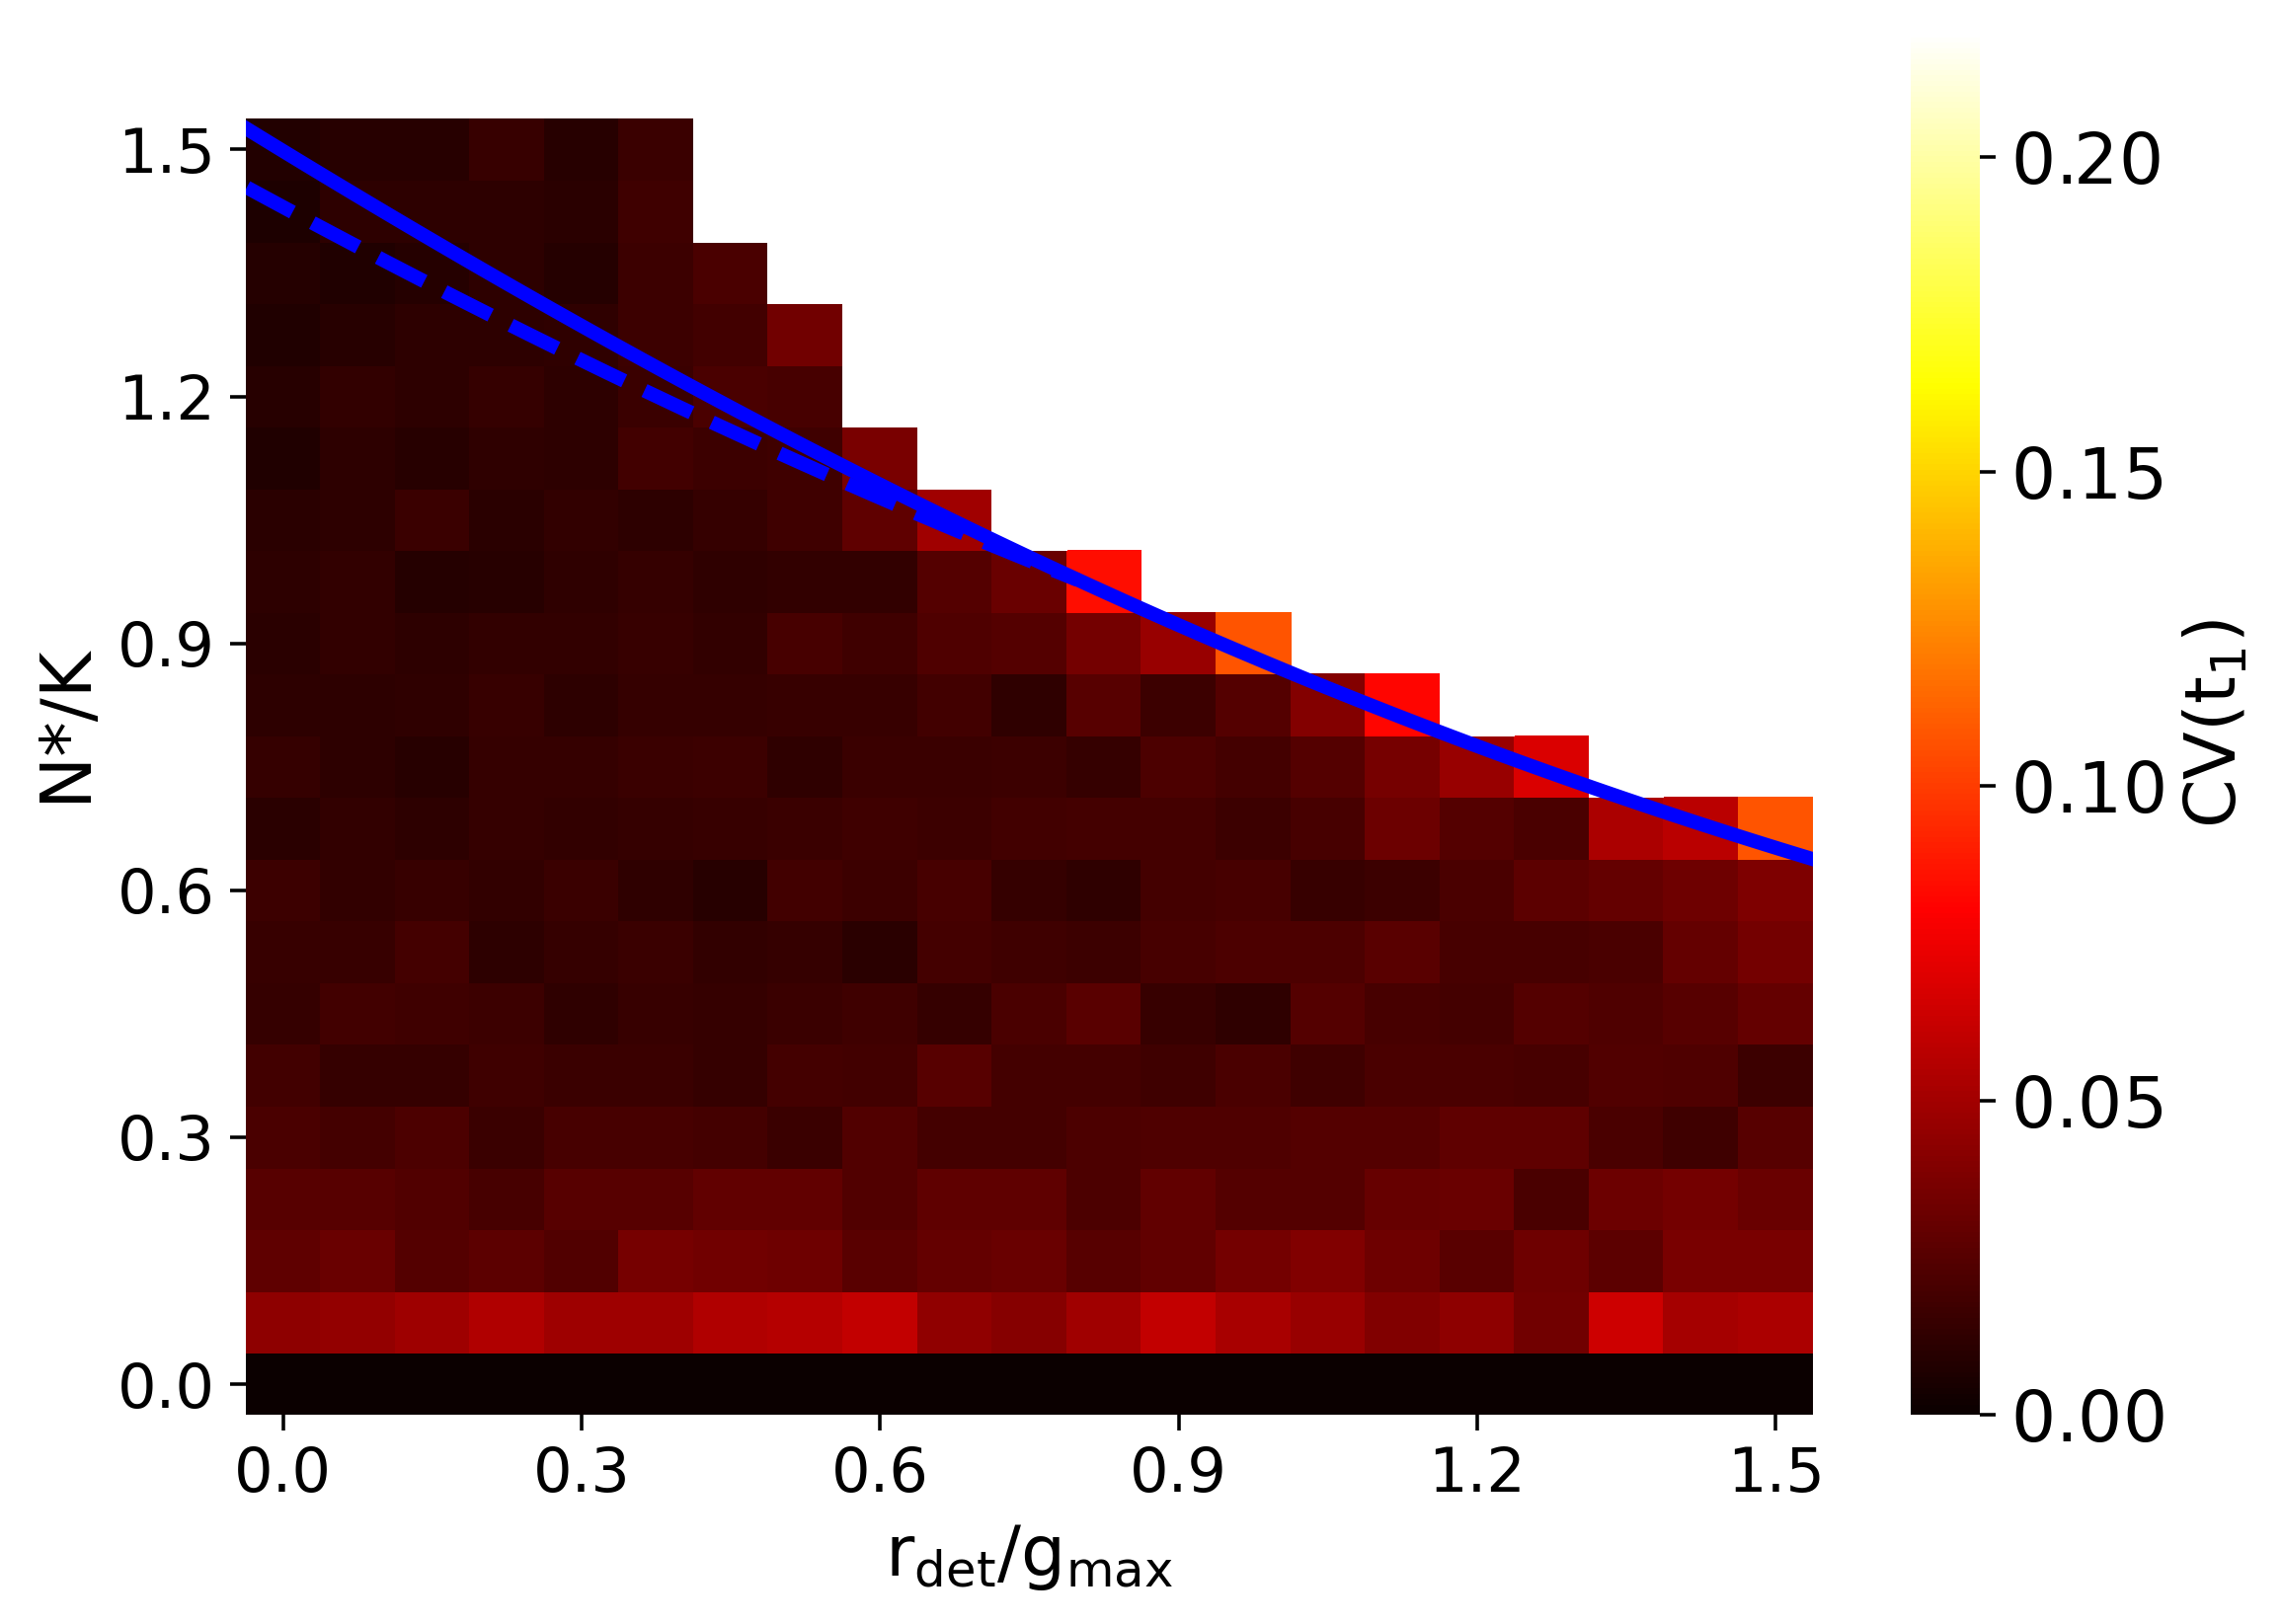

In [12]:
fig, ax = plt.subplots(dpi=320)
fig.set_size_inches(8, 5.8)
titleSize = 16
labelSize = 16
numbersize = 14
legendsize = 10
IDsize=12


import matplotlib.ticker as tkr
formatter = tkr.ScalarFormatter(useMathText=True)
# formatter.set_scientific(True)
# formatter.set_powerlimits((-3, -2))

# #this mask will only plot values between 15 and 20
# masko = (pivot < 15) | (pivot >= 20)

# #phase_mask = (pivot['det_ratio']) > 0.5

ax = sns.heatmap(pivot_stDev, annot=False, cmap='hot', xticklabels = 4, yticklabels=4, rasterized=True, cbar_kws={'format':formatter})
# ax_masked = sns.heatmap(pivot, mask=masko, cmap='Greens', cbar=False, annot=True)
# #ax_masked2 = sns.heatmap(pivot, mask=phase_mask, cmap='Blues', cbar=False, annot=True)

ax.invert_yaxis()
labels_x = [label.get_text() for label in ax.get_xticklabels()]
ax.set_xticklabels(map(lambda x: "{:.1f}".format(float(x)), labels_x))
labels_y = [label.get_text() for label in ax.get_yticklabels()]
ax.set_yticklabels(map(lambda y: "{:.1f}".format(float(y)), labels_y))

#plot the theoretical blue line #####################
theoryN_vals = np.vectorize(phase_diag_line)(det_ratio_vals)
# theoryN_vals[0] = 1.5
# theoryN_vals[-1] = 0.6
print(theoryN_vals[0])
print(theoryN_vals[-1])

#in order to get the line to be positioned correctly, need to multiply it by this scale factor.
#equal to the max value of the line divided by no. of squares in each axis
nsquares = len(param_data.index)**0.5 #no. of squares in each axis
scale_factor_x = nsquares/1.5
scale_factor_y = nsquares/1.5
sns.lineplot(x=det_ratio_vals*scale_factor_x, y=theoryN_vals*scale_factor_y, linewidth = 3.2, color="blue")
line = ax.lines[0] # get the line
line.set_ydata(line.get_ydata() - 0.5)



#plot the dashed line
det_ratio_vals_dashed = dashed_line_vals["r_det_ratio"]
theoryN_vals_dashed = dashed_line_vals["N_theory"]
print(theoryN_vals_dashed[0])
print(np.min(theoryN_vals_dashed))

scale_factor_x_dashed = nsquares/1.5
scale_factor_y_dashed = nsquares/1.5

sns.lineplot(x=det_ratio_vals_dashed*scale_factor_x_dashed, y=theoryN_vals_dashed*scale_factor_y_dashed, linewidth = 3.2, color="blue")
line = ax.lines[1] # get the line
line.set_ydata(line.get_ydata() - 0.5)
line.set_linestyle("--")
###########################################



ax.axis('tight')

ax.set_xlabel('r$_{\\rm det}/\\rm{g}_{\max}$', fontsize=labelSize)
ax.set_ylabel('N*/K', fontsize=labelSize)
ax.xaxis.set_tick_params(labelsize=numbersize)
ax.yaxis.set_tick_params(labelsize=numbersize)


cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=labelSize)
cbar.set_label("CV(t$_1$)", fontsize=labelSize)

#cbar = plt.colorbar()
cbar.ax.locator_params(nbins=6)

plt.xticks(rotation=0)
plt.savefig('paper_plots/CV_t1_heatmap.pdf', bbox_inches='tight')
plt.show()

In [13]:
def get_t1_vs_r_det(param_df, N_thresh):
    '''
    To see how t1 varies with the parameters, we'll plot a series of line graphs.  Each line will be a different value of N*,
    x axis will be r_det and y-axis will be t1.  (Essentially going from left to right on the heatmaps)
    
    DON'T FORGET TO REMOVE THE AESTHETIC ALTERATIONS MADE TO THE DATAFRAME AT THE START OF THE NOTEBOOK.
    '''
    
    r_det_vals = param_df["det_ratio"][np.isclose(param_df["n_thresh"], N_thresh)]
    t1_vals = param_df["tN_adjusted"][np.isclose(param_df["n_thresh"], N_thresh)]
    #print(r_det_vals)
    return r_det_vals, t1_vals

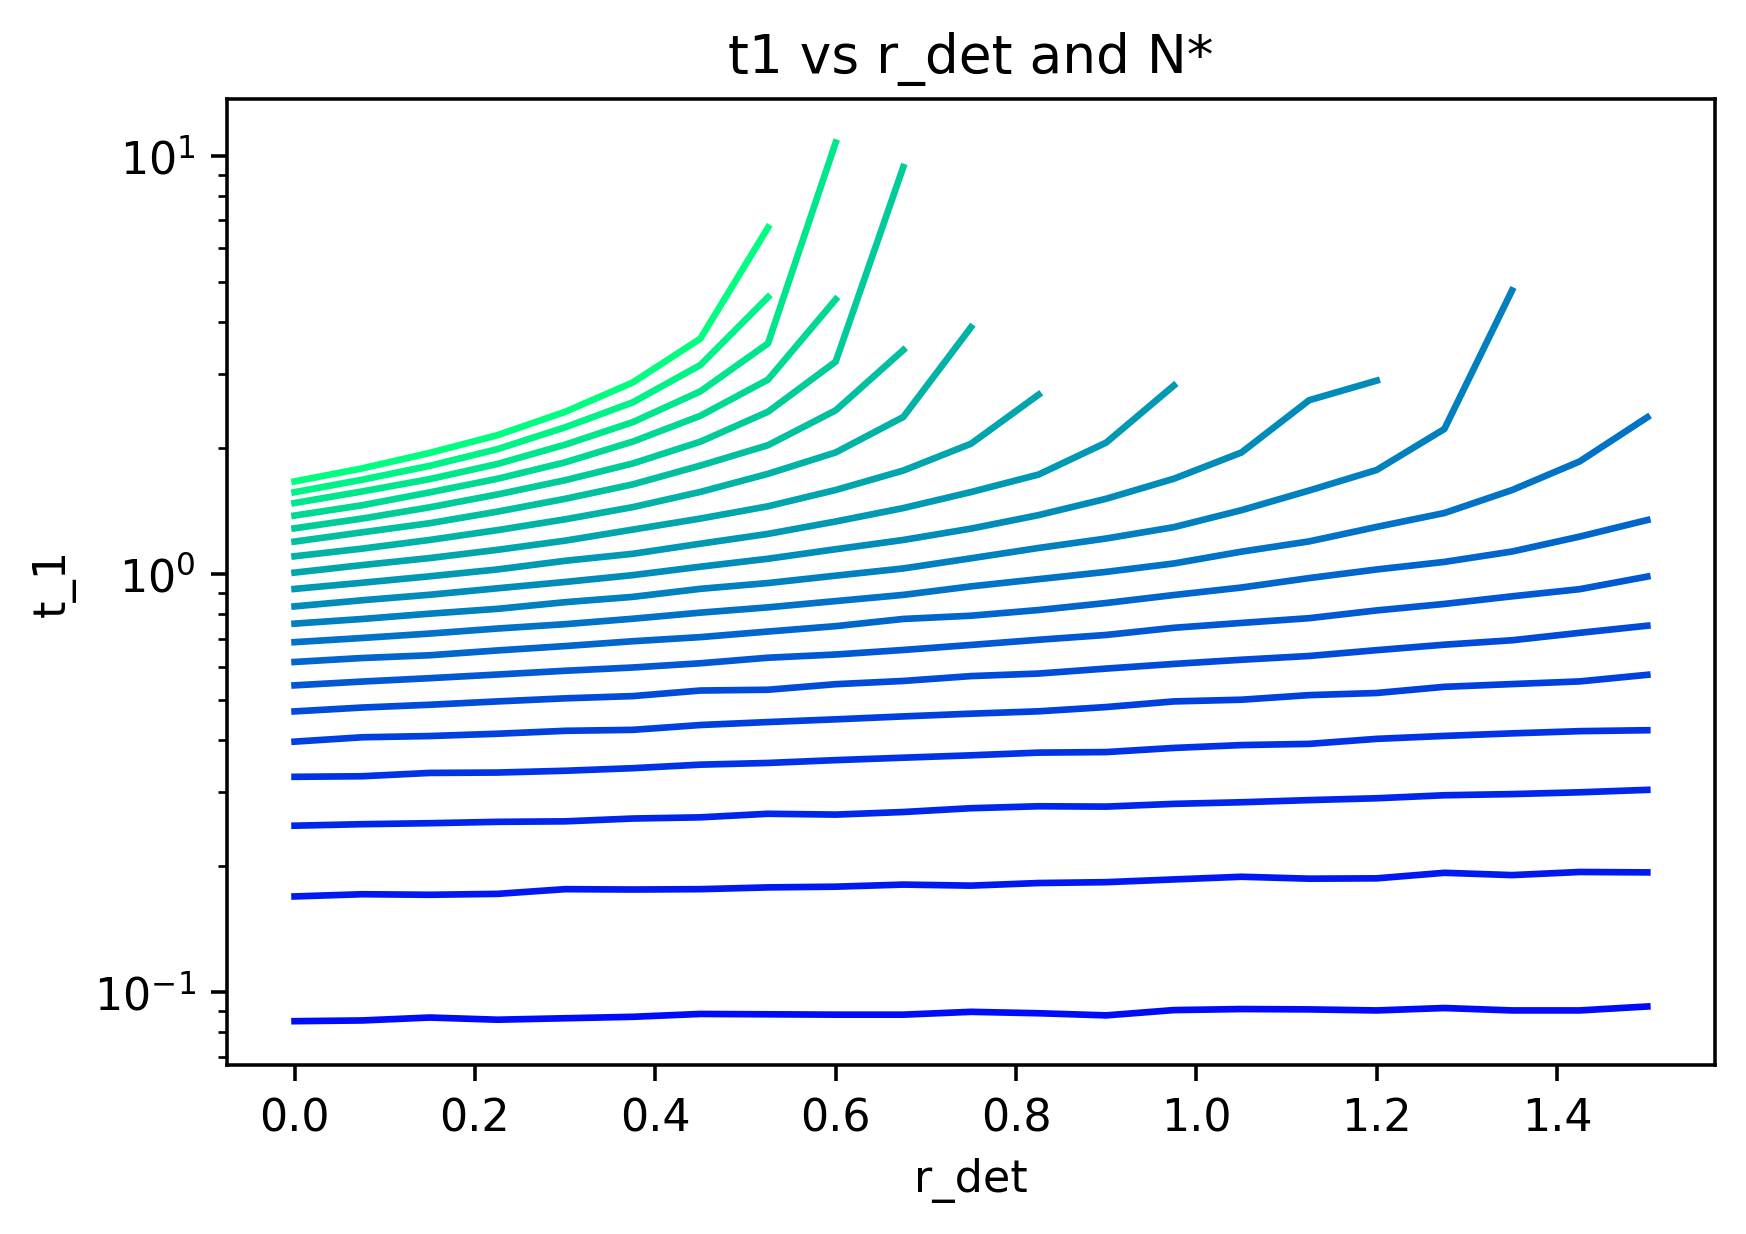

In [14]:
fig, ax = plt.subplots(dpi=320)

n_thresh_vals = np.arange(N_thresh_min, N_thresh_max+delta_N_thresh, delta_N_thresh)
nCols = n_thresh_vals.size #no. of runs. -1 due to the time column
colors = pl.cm.winter(np.linspace(0,1,nCols))
i = 0

for n_thresh in n_thresh_vals:
    #print(n_thresh)
    r_det_data, t1_data = get_t1_vs_r_det(param_data, n_thresh)
    
    ax.plot(r_det_data, t1_data, color=colors[i], label=n_thresh)
    i += 1

#plt.semilogy()
#plt.legend(ncol=3)
plt.xlabel("r_det")
plt.ylabel("t_1")
plt.title("t1 vs r_det and N*")

plt.savefig("paper_plots/heatmap_powerlaw.png")
plt.semilogy()
plt.savefig("paper_plots/heatmap_powerlaw_logy.png")
plt.show()

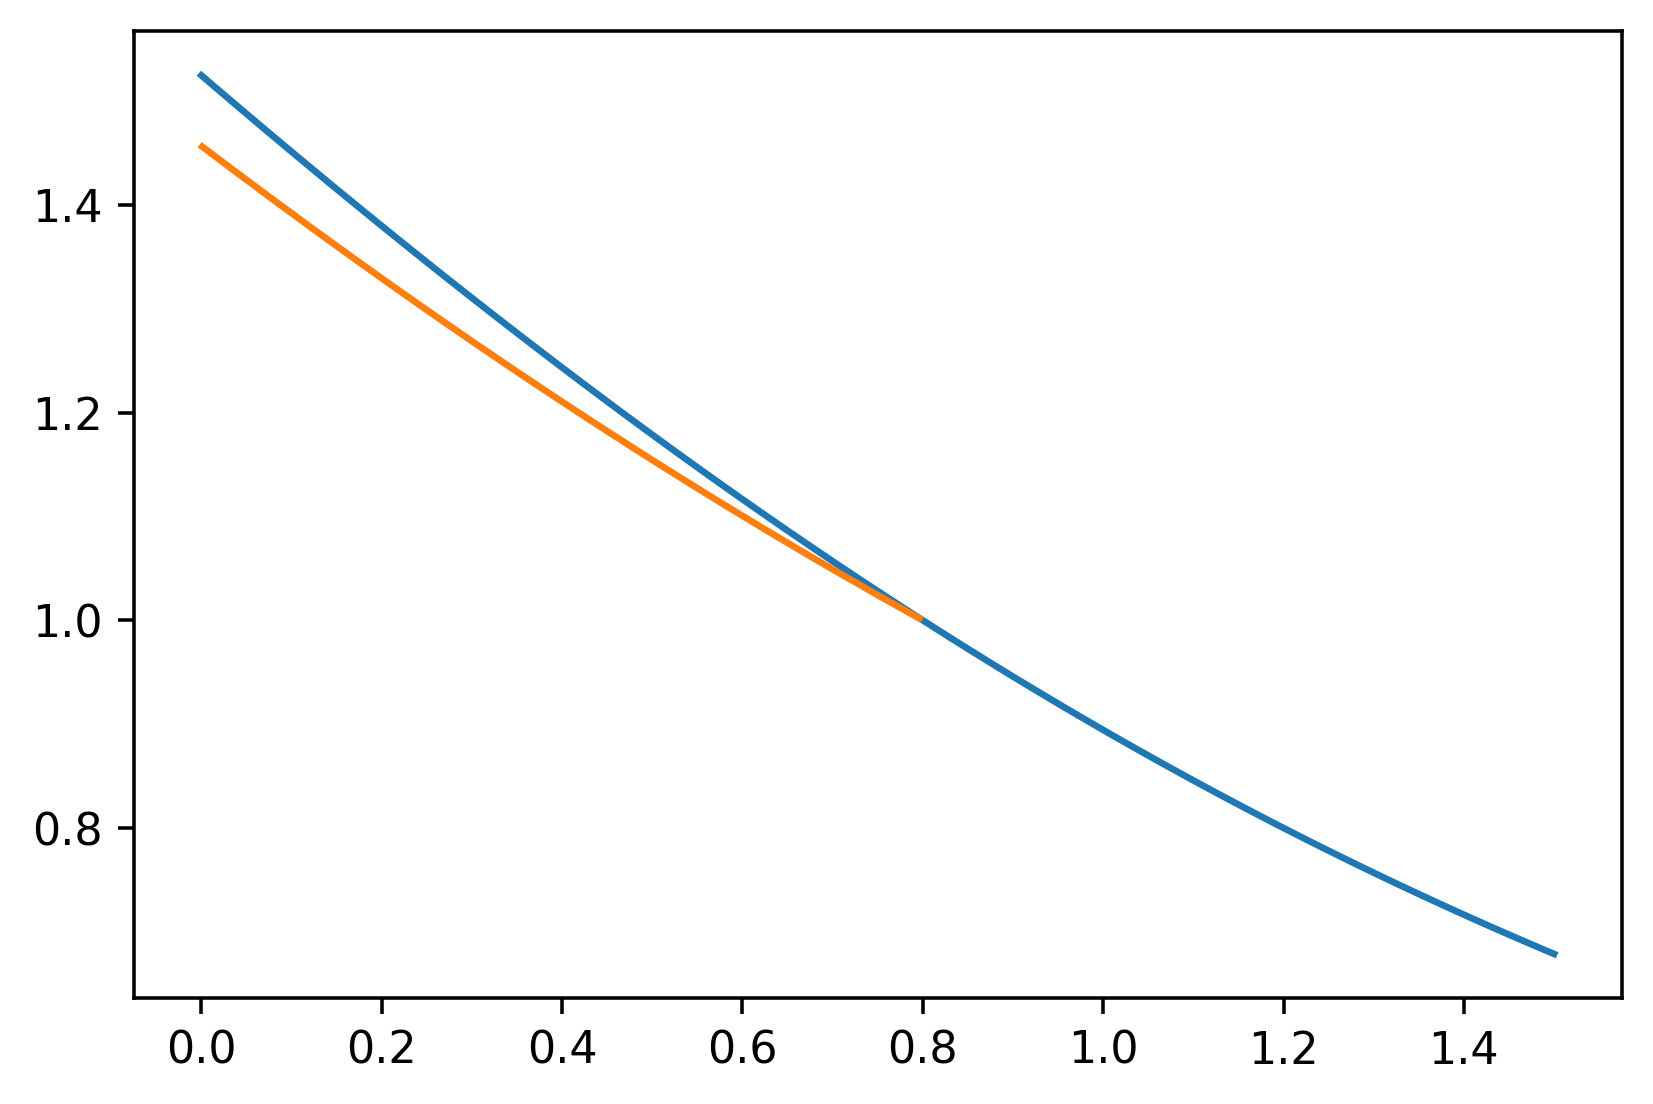

In [15]:
fig, ax = plt.subplots(dpi=320)
ax.plot(det_ratio_vals, np.vectorize(phase_diag_line)(det_ratio_vals))

det_ratio_vals_dashed = dashed_line_vals["r_det_ratio"]
theoryN_vals_dashed = dashed_line_vals["N_theory"]

ax.plot(det_ratio_vals_dashed, theoryN_vals_dashed)

In [16]:
print(param_data["coeff_variation"][~np.isnan(param_data["coeff_variation"])])

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
423    0.014764
424    0.009513
425    0.015738
426    0.220000
427    0.220000
Name: coeff_variation, Length: 337, dtype: float64


In [17]:
print(param_data)

     n_thresh  det_ratio  time_to_n  time_elapsed  time_to_n_raw  \
0         0.0      0.000        0.0  9.000000e+09            0.0   
1         0.0      0.075        0.0  9.000000e+09            0.0   
2         0.0      0.150        0.0  9.000000e+09            0.0   
3         0.0      0.225        0.0  9.000000e+09            0.0   
4         0.0      0.300        0.0  9.000000e+09            0.0   
..        ...        ...        ...           ...            ...   
436       1.5      1.200        0.0  2.560460e+02            0.0   
437       1.5      1.275        0.0  2.560527e+02            0.0   
438       1.5      1.350        0.0  2.560466e+02            0.0   
439       1.5      1.425        0.0  2.560524e+02            0.0   
440       1.5      1.500        0.0  2.560489e+02            0.0   

     time_to_n_stDev  coeff_variation  tN_adjusted  tN_stDev_adjusted  \
0                0.0              0.0          0.0                0.0   
1                0.0              0.0

(array([42., 32., 30., 29., 27., 24., 19., 18., 15., 11., 12., 10.,  7.,
         8.,  3.,  3.,  6.,  2.,  2.,  4.]),
 array([0.085075  , 0.22649057, 0.36790615, 0.50932172, 0.65073729,
        0.79215286, 0.93356844, 1.07498401, 1.21639958, 1.35781516,
        1.49923073, 1.6406463 , 1.78206188, 1.92347745, 2.06489302,
        2.20630859, 2.34772417, 2.48913974, 2.63055531, 2.77197089,
        2.91338646]),
 <a list of 20 Patch objects>)

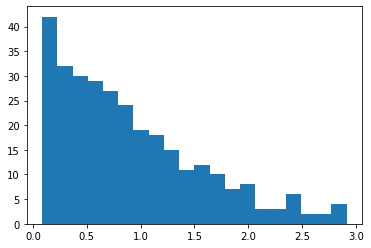

In [18]:
plt.hist(param_data["tN_adjusted"][(param_data["tN_adjusted"]>0) & (param_data["tN_adjusted"]<3)].values, bins=20)
#plt.show()